# Semantic segmentation

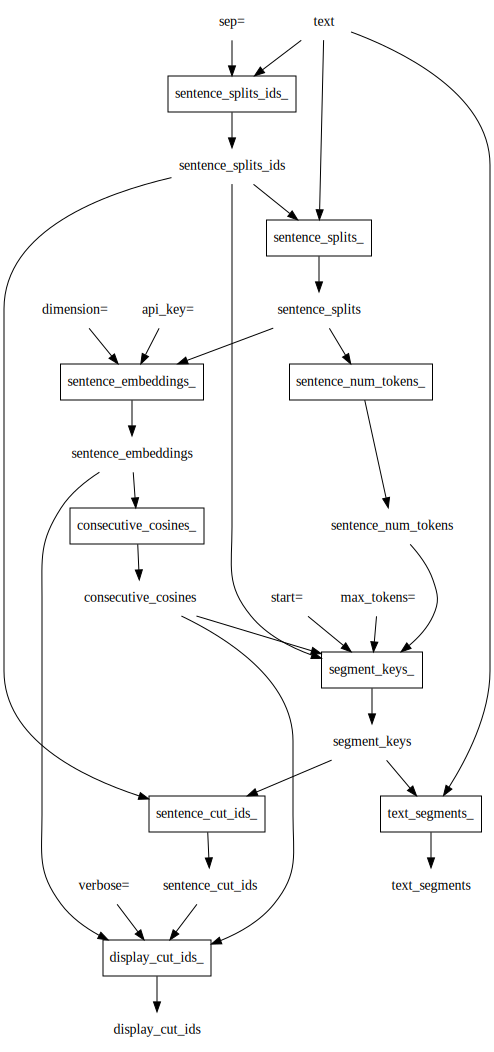

In [14]:
from segmentation_lib import segmentation_dag
segmentation_dag.dot_digraph()

In [1]:
my_text = """
              Pierre aime jouer au football et lire des livres. Il passe beaucoup de temps à la bibliothèque. C'est un lieux idéal pour lui pour se détendre.\n
            
              Je pense, Madame, que vous avez raison au sujet de la performance de l'entreprise allemande. La seconde guerre mondiale a effectivement été un désastre.
              Beacoup de livres ont été écrits sur le sujet.
            
              English is a language that is spoken by many people.
              It is now the most spoken language in the world.
              Because of the British Empire, English has become a global language.
              During the World War II, the British Empire was at its peak"""


In [ ]:
segmentation_dag[:](text = my_text, max_tokens = 50)                 

In [2]:
from segmentation_lib import character_chunker
character_chunker(text = my_text, max_chunk_size= 10)

[(0, 64),
 (64, 110),
 (110, 158),
 (158, 279),
 (279, 339),
 (339, 400),
 (400, 480),
 (480, 543),
 (543, 626),
 (626, 700)]

# Retrieval functions

In [3]:
from raglab.retrieval.lib_alexis import dag, generate_split_keys
doc_embeddings = dag[:"doc_embeddings"]
top_k = dag["user_query":"top_k_segments"]

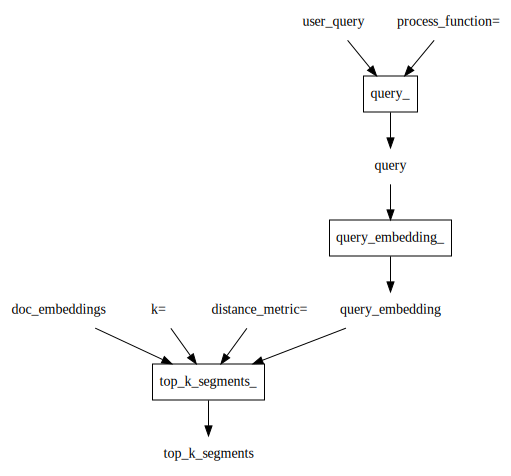

In [9]:
top_k.dot_digraph()

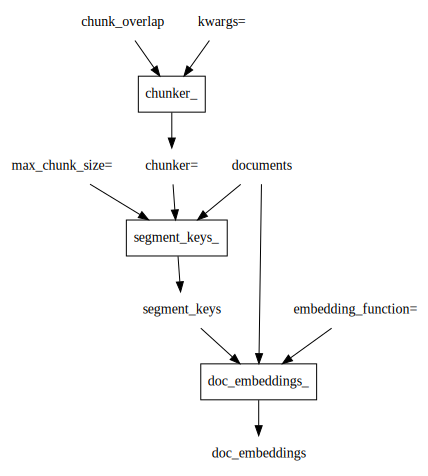

In [10]:
doc_embeddings.dot_digraph()

# Testing

test data

In [4]:
from dol import Files
from raglab.retrieval.lib_alexis import extension_base_wrap
test_responces = extension_base_wrap(Files("./data_ad/QA"))
test_documents = extension_base_wrap(Files("./data_ad/test_documents"))
print(f"test repsonces", list(test_responces))
print(f"test documents", list(test_documents))

test repsonces ['eval1.json', 'story_qa.json']
test documents ['Contrat_ONE1406.pdf', 'story.txt', 'contract1.txt', 'writers.txt']


In [5]:
test_qa = test_responces["eval1.json"]
test_txt = test_documents["contract1.txt"]
test_doc = {"contract1": test_txt}

In [101]:
# display segmentation
segmentation_dag[:"display_cut_ids"](text=test_txt, max_tokens=700)

In [28]:
from functools import partial
_generate_split_keys =  partial(generate_split_keys, chunk_overlap=40, max_chunk_size=10_000)

In [6]:
from segmentation_lib import character_chunker

In [84]:
def semantic_doc_chunker(docs, max_chunk_size):
    segment_keys = []
    for doc_name, doc_txt in docs.items():
        sk = segmentation_dag[:"segment_keys"](text=doc_txt, max_tokens=max_chunk_size)
        for start, stop in sk:
            segment_keys.append((doc_name, start, stop))
    return segment_keys


In [89]:
def char_doc_chunker(docs, max_chunk_size):
    segment_keys = []
    for doc_name, doc_txt in docs.items():
        sk = character_chunker(text=doc_txt, max_chunk_size=max_chunk_size)
        for start, stop in sk:
            segment_keys.append((doc_name, start, stop))
    return segment_keys

In [44]:
from segmentation_lib import segment_keys
from functools import partial
segment_keys_= partial(segment_keys, language= "english")


In [45]:
from functools import partial
pipeline = partial(top_k, doc_embeddings=doc_embed)

In [36]:
from raglab.suggestion_engine.suggestion_lib import set_from_text

In [78]:
def test_retrieval(chunker, max_chunk_size, verbose=False):
    doc_embed = doc_embeddings["chunker":](documents=test_doc, chunker = chunker, max_chunk_size=max_chunk_size)
    score = 0
    precision = 0
    recall = 0
    for query, responce in test_qa.items():
        if verbose:
            print(f"\n-------------\n Query: {query}")
            print(f"Expected: {responce}")
        True_set = set_from_text(responce)
        res = top_k(user_query=query, k=1, doc_embeddings=doc_embed)
        segment_key=res[0]
        predicted_set = set_from_text(test_doc[res[0][0]][res[0][1]:res[0][2]])
        precision += len(True_set.intersection(predicted_set)) / len(predicted_set)
        recall += len(True_set.intersection(predicted_set)) / len(True_set)
        if responce in test_doc[segment_key[0]][segment_key[1]:segment_key[2]]:
            score += 1
        if verbose:
            print(f"Predicted: {test_doc[segment_key[0]][segment_key[1]:segment_key[2]]}")

    print(f"precision: {precision/len(test_qa)}")
    print(f"recall: {recall/len(test_qa)}")
    print(f"\nScore: {score}/{len(test_qa)}")
    return precision/len(test_qa), recall/len(test_qa), score/len(test_qa)

In [95]:
max_sizes = [100, 200, 300, 400, 500, 600, 700]
precisions = []
recalls = []
scores = []
chunker = semantic_doc_chunker
# chunker = char_doc_chunker
for max_size in max_sizes:
    p,r,s = test_retrieval(chunker, max_size)
    precisions.append(p)
    recalls.append(r)
    scores.append(s)

precision: 0.3505398380141183
recall: 0.7294028722600151

Score: 15/21
precision: 0.24561693179690636
recall: 0.7338864838864838

Score: 15/21
precision: 0.179644316179036
recall: 0.7978658768132453

Score: 16/21
precision: 0.11635185370735532
recall: 0.9311373672275927

Score: 19/21
precision: 0.0736746947948265
recall: 0.9311373672275927

Score: 19/21
precision: 0.07142616002766378
recall: 0.9425547996976569

Score: 19/21
precision: 0.07142616002766378
recall: 0.9425547996976569

Score: 19/21


In [96]:
s_precisions = precisions
s_recalls = recalls
s_scores = scores

In [93]:
c_precisions = precisions
c_recalls = recalls
c_scores = scores

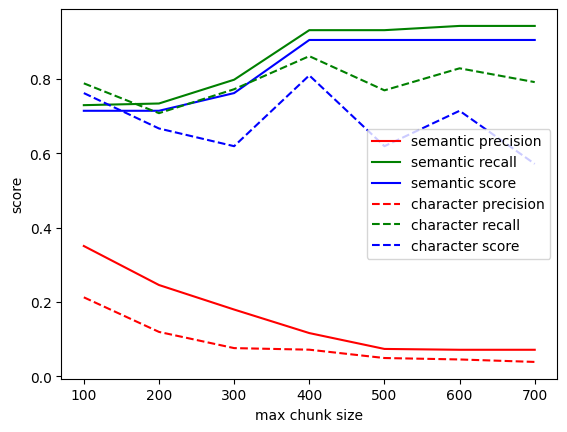

In [100]:
import matplotlib.pyplot as plt
plt.plot(max_sizes, s_precisions, label="semantic precision", color="red")
plt.plot(max_sizes, s_recalls, label="semantic recall", color="green")
plt.plot(max_sizes, s_scores, label="semantic score", color="blue")
plt.plot(max_sizes, c_precisions, label="character precision", linestyle="--", color="red")
plt.plot(max_sizes, c_recalls, label="character recall", linestyle="--", color="green")
plt.plot(max_sizes, c_scores, label="character score", linestyle="--", color="blue")
plt.xlabel("max chunk size")
plt.ylabel("score")
plt.legend()
plt.show()

# visualize embeddings

In [39]:
# dump .tsv file to save vectors
vectors = list(doc_embed.values()) + dag["user_query":"query_embedding"](user_query="Une personne qui habite une ville côtière")
labels = list(doc_embed.keys()) + ["Une personne qui habite une ville côtière"]


In [34]:
"a \n".replace("\n", "")

'a '

In [44]:
# visualisation of embaddings with labels
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(list(doc_embed.values()))
sentences = [d[key[0]][key[1]:key[2]] for key in doc_embed.keys()]
print(len(principalComponents), len(sentences))
sentence_embd = zip(sentences, principalComponents)
with open("embeddings_story.tsv", "w") as f:
    with open("embeddings_metadata_story.tsv", "w") as fm:
        for k, v in sentence_embd :
            fm.write(k.replace("\n", "") + "\n")
            f.write("\t".join([str(x).replace("\n", "") for x in v]) + "\n")
            print(v,k)


25 25
[ 0.263606   -0.16116216  0.24300912] Il était une fois dans une petite ville au bord de la mer, vivait un jeune garçon nommé Pierre. Pierre aimait passer ses journées à explorer les plages, à chercher des coquillages brillants et à
[ 0.15252536 -0.03040171 -0.14722567] chercher des coquillages brillants et à construire des châteaux de sable.
[ 0.32028301 -0.09492968  0.2574581 ] Un jour, alors qu'il se promenait sur la plage, Pierre découvrit une bouteille mystérieuse échouée sur le sable. Il la ramassa avec curiosité et la déboucha pour voir ce qu'elle contenait. À sa
[ 0.21093002  0.05010822 -0.19036478] pour voir ce qu'elle contenait. À sa grande surprise, une petite carte était enroulée à l'intérieur.
[ 0.2480553   0.02308763 -0.13970906] La carte indiquait un endroit secret sur l'île où se trouvait un trésor caché depuis des siècles. Excité par cette découverte, Pierre décida de partir à l'aventure pour trouver le trésor.
[0.31339917 0.07151561 0.13113321] Il marcha à trave

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.00505012 -0.01125633  0.02729863 ... -0.01323909 -0.01103879
 -0.01737863].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [9]:
for k in doc_embed:
    print(d[k[0]][k[1]:k[2]])
    print("\n")

Il était une fois dans une petite ville au bord de la mer, vivait un jeune garçon nommé Pierre.


vivait un jeune garçon nommé Pierre. Pierre aimait passer ses journées à explorer les plages, à


ses journées à explorer les plages, à chercher des coquillages brillants et à construire des


brillants et à construire des châteaux de sable.


Un jour, alors qu'il se promenait sur la plage, Pierre découvrit une bouteille mystérieuse échouée


une bouteille mystérieuse échouée sur le sable. Il la ramassa avec curiosité et la déboucha pour


avec curiosité et la déboucha pour voir ce qu'elle contenait. À sa grande surprise, une petite


À sa grande surprise, une petite carte était enroulée à l'intérieur.


La carte indiquait un endroit secret sur l'île où se trouvait un trésor caché depuis des siècles.


un trésor caché depuis des siècles. Excité par cette découverte, Pierre décida de partir à


découverte, Pierre décida de partir à l'aventure pour trouver le trésor.


Il marcha à travers la